In [73]:
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np

# Declaração de métodos

In [74]:
Ponto = Tuple[float, float]
Intervalo = Tuple[float, float]
CoeficientesTridiagonal = Tuple[float, float, float]
Fx = Callable[[float], float]

In [75]:
def tridiag(coefs: CoeficientesTridiagonal, n: int):
    a, b, c = coefs
    mat = np.zeros((n, n))
    for i in range(n):
        mat[i, i] = b
        if i != 0:
            mat[i, i - 1] = a
        if i != n-1:
            mat[i, i + 1] = c
    return mat

In [76]:
def newton_jac(
    calc_jac: Callable[[np.ndarray], np.ndarray],
    calc_F: Callable[[np.ndarray, np.ndarray], np.ndarray],
    x: np.ndarray,
    N: int,
    y_contorno: Intervalo,
    tol: float = 1.0e-3
):
    y = np.zeros(N)
    y[0] = y_contorno[0]
    y[-1] = y_contorno[1]
    error = 2 * tol
    n_iter = 0
    while error > tol:
        y_next = y.copy()
        Jf = calc_jac(y)
        F = calc_F(x, y)
        s = np.linalg.solve(Jf, -F)
        for i in range(N - 2):
            n = i + 1
            y_next[n] = y[n] + s[i]
        error = np.linalg.norm(y_next - y) / np.linalg.norm(y_next)
        y = y_next
        n_iter += 1
    return x, y, n_iter

# Exercício 1.

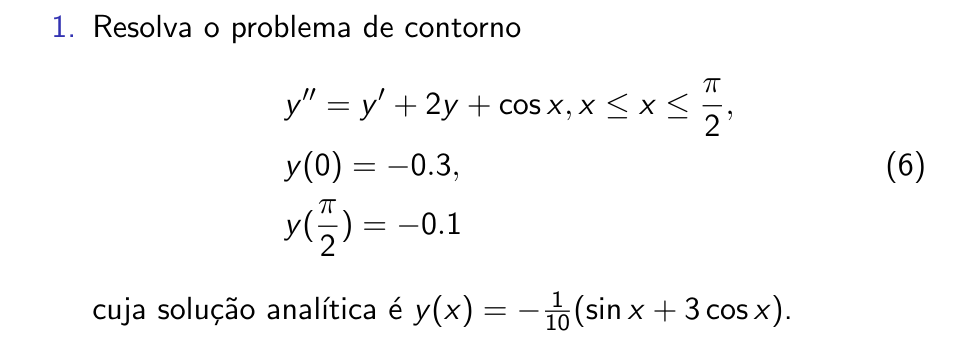

Dada a equação diferencial

$$ y'' = y' + 2y + \cos(x),\ x \leqslant 0 \leqslant \frac{\pi}{2} $$
$$ y(0) = -0.3 $$
$$ y\left( \frac{\pi}{2} \right) = -0.1 $$

Substituindo as derivadas pelas diferenças finitas centradas:

$$ \frac{y_{i+1} - 2y_{i} + y_{i - 1}}{h^2} = \frac{y_{i+1}-y_{i-1}}{2h} + 2y_i + \cos(x_i) $$

$$ 2y_{i+1} - 4y_i + 2y_{i-1} = hy_{i+1} - hy_{i-1} + 4h^2y_i + 2h^2 \cos(x_i) $$

$$ (2 - h)y_{i+1} + (-4 - 4h^2)y_i + (2 + h)y_{i-1} = 2h^2 \cos(x_i) $$

Os coeficientes $a,b,c$ que formam a matriz tridiagonal são dados por:

$$ a = 2+h,\quad b = -4-4h^2,\quad c = 2-h $$

In [77]:
# Solução analítica
ex1_exata: Fx = lambda x: (-1 / 10) * (np.sin(x) + 3 * np.cos(x))

# Tamanho da malha (pontos)
ex1_x0 = 0
ex1_xf = np.pi / 2
# Contorno
ex1_y0 = -0.3
ex1_yf = -0.1
ex1_N = 11
ex1_x = np.linspace(ex1_x0, ex1_xf, ex1_N)
ex1_h = ex1_x[1] - ex1_x[0]
ex1_coefs = (2 + ex1_h, -4 - 4 * (ex1_h ** 2), 2 - ex1_h)
# Vetor resultante
ex1_b = 2 * (ex1_h ** 2) * np.cos(ex1_x[1:-1])
# Condições de contorno
ex1_b[0] = ex1_b[0] - ex1_coefs[0] * ex1_y0
ex1_b[-1] = ex1_b[-1] - ex1_coefs[2] * ex1_yf
ex1_A = tridiag(ex1_coefs, ex1_N-2)
# Resolução
ex1_sol_inner = np.linalg.solve(ex1_A, ex1_b)
ex1_sol = np.array([ex1_y0, *ex1_sol_inner, ex1_yf])

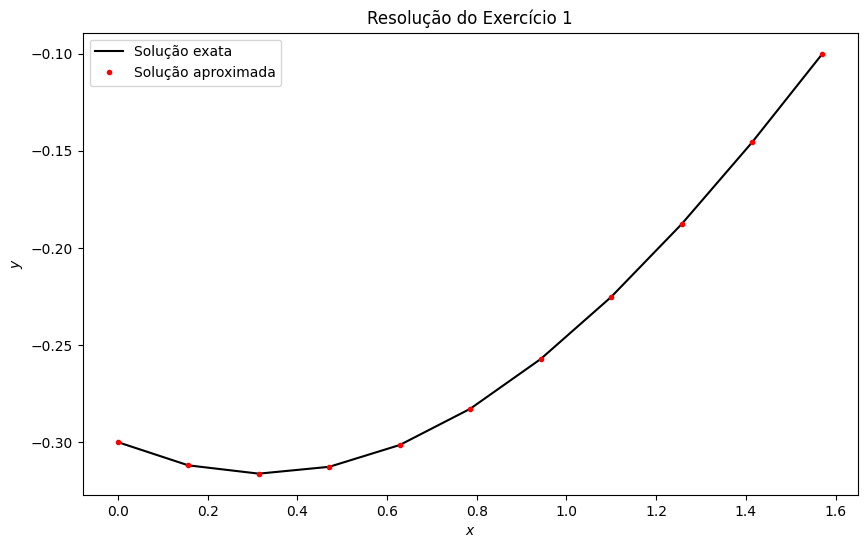

In [78]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ex1_x, ex1_exata(ex1_x), "-k", label="Solução exata")
ax.plot(ex1_x, ex1_sol, ".r", label="Solução aproximada")
ax.legend()
ax.set_title("Resolução do Exercício 1")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.show()

# Exercício 2.

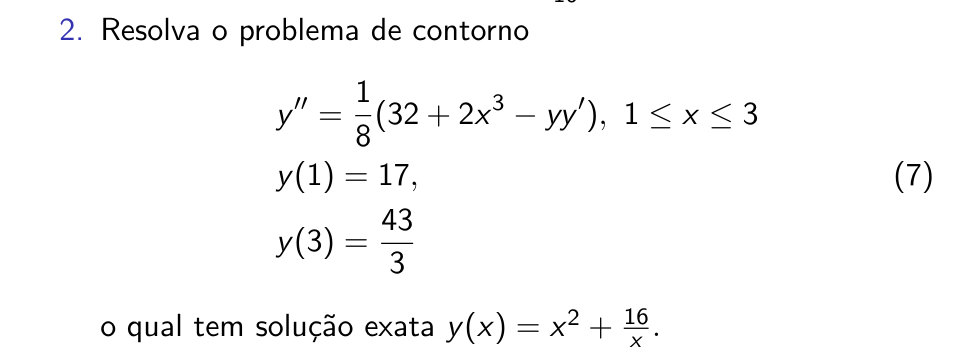

Discretizando a ED:

$$ \frac{y_{i+1} - 2y_i + y_{i-1}}{h^2} = \frac{1}{8} \left(32 + 2x_i^3 - y_i \frac{y_{i+1} - y_{i-1}}{2h} \right) $$

$$ 2y_{i+1} - 4y_i + 2y_{i-1} = \frac{h^2}{4} \left(32 + 2x_i^3 - y_i \frac{y_{i+1} - y_{i-1}}{2h} \right) $$

$$ 2y_{i+1} - 4y_i + 2y_{i-1} = 8h^2 + \frac{h^2 x_i^3}{2} - \frac{hy_i y_{i+1} - hy_i y_{i-1}}{8} $$

$$ y_{i+1} \left( 2 + \frac{h y_i}{8} \right) + y_i (-4) + y_{i-1} \left( 2 - \frac{h y_i}{8} \right) - 8h^2 - \frac{h^2 x_i^3}{2} =0  $$

$$ 2y_{i+1} + \frac{h y_i y_{i+1}}{8} - 4y_i + 2y_{i-1} - \frac{h y_i y_{i-1}}{8} - 8h^2 - \frac{h^2 x_i^3}{2} = 0 $$

A expressão para calcular a Jacobiana depende das derivadas parciais em relação a cada um dos $y$:

$$ \frac{\partial F_i}{\partial y_{i+1}} = 2 + \frac{h y_i}{8} $$
$$ \frac{\partial F_i}{\partial y_{i}} = -4 + \frac{h y_{i+1}}{8} - \frac{h y_{i-1}}{8} $$
$$ \frac{\partial F_i}{\partial y_{i-1}} = 2 - \frac{h y_i}{8} $$

In [79]:
ex2_exata: Fx = lambda x: (x ** 2) + 16 / x

ex2_x0 = 1
ex2_xf = 3
ex2_y0 = 17
ex2_yf = 43 / 3
ex2_N = 11
ex2_x = np.linspace(ex2_x0, ex2_xf, ex2_N)
ex2_h = ex2_x[1] - ex2_x[0]
common_factor = ex2_h / 8

# Cálculo da Jacobiana
def ex2_jac(y: np.ndarray):
    size = y.shape[0] - 2
    mat = np.zeros((size, size))
    for i in range(size):
        n = i + 1
        mat[i, i] = -4 + common_factor * (y[n + 1] - y[n - 1])
        if i != 0:
            mat[i, i - 1] = 2 - common_factor * y[n]
        if i != size - 1:
            mat[i, i + 1] = 2 + common_factor * y[n]
    return mat

# Cálculo da Função não-linear
def ex2_F(x: np.ndarray, y: np.ndarray):
    size = y.shape[0] - 2
    F = np.zeros(size)
    for i in range(size):
        n = i + 1
        F[i] = (
            2 * y[n + 1] +
            common_factor * y[n] * y[n + 1] -
            4 * y[n] + 2 * y[n - 1] -
            common_factor * y[n] * y[n - 1] -
            8 * (ex2_h ** 2) -
            ((ex2_h ** 2) * (x[n] ** 3))/2
        )
    return F

(ex2_x, ex2_sol, ex2_iter) = newton_jac(
    ex2_jac,
    ex2_F,
    ex2_x,
    ex2_N,
    (ex2_y0, ex2_yf)
)

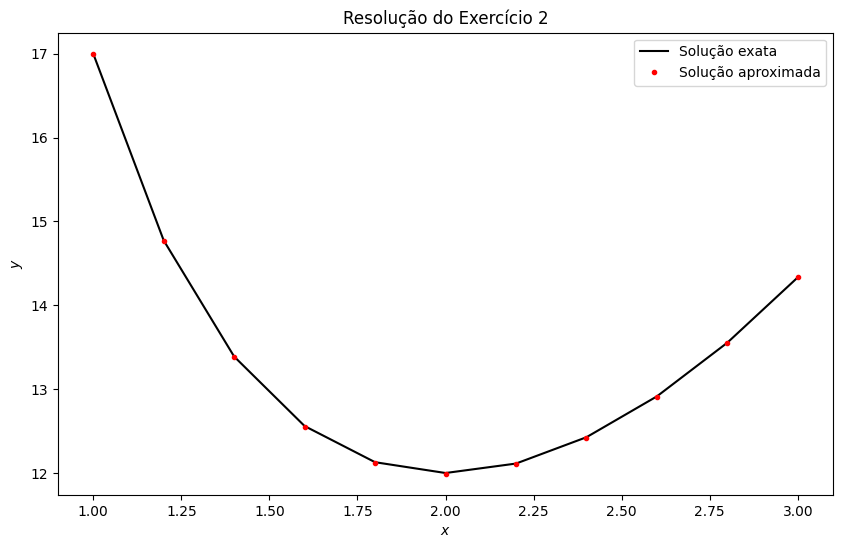

In [80]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ex2_x, ex2_exata(ex2_x), "-k", label="Solução exata")
ax.plot(ex2_x, ex2_sol, ".r", label="Solução aproximada")
ax.legend()
ax.set_title("Resolução do Exercício 2")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.show()